In [2]:
# Numerical
from jax.numpy import mean, var    # Arithematic
from jax.numpy import array, zeros # Array creation routines
from jax.lax import scan 
from jax import jit, jacrev, jacfwd

# Miscellaneous
from functools import partial 
from time import process_time
from ticktack import load_presaved_model
from ticktack.fitting import SingleFitter

# ODEINTs
from ticktack.bogacki_shampine import odeint as BS3
from ticktack.dormand_prince import odeint as DP5

# Visualisation
from pandas import DataFrame
from plotnine import *

In [3]:
parameters = (774.86, 0.25, 0.8, 6.44)

In [4]:
def profile(func, *args, **kwargs) -> tuple:
    """
    Profiles the function, func, with the arguments, args, returning the speed and the variance of the speed.
    """
    time_sample = zeros(10)  # Storing the trials
    
    for i in range(10):
        timer = process_time()             # Starting a timer 
        solution = func(*args, **kwargs)   # Running the model 
        map(array, solution) # Forcing vistation of the values (equivalent to block_until_ready)
        timer = process_time() - timer     # Stopping the timer

        time_sample = time_sample.at[i].set(timer)  # Storing the timer 

    return {
        "average": mean(time_sample.at[1:].get()), 
        "variance": var(time_sample),
        "solution": solution
        }

In [5]:
def odeint_linear(derivative, y0, timesteps, *args, **kwargs):
    """
    A linear ode solver that is designed to be compatible with the `ticktack` architecture. 
    """
    step_size = timesteps[1] - timesteps[0]

    def step(y, time_value, step_size=None, derivative=None):
        """
        A utility function that is passed through scan(map) to produce the final result.
        """
        next_time_value = y + derivative(y, time_value) * step_size
        return next_time_value, next_time_value

    step = partial(step, derivative=derivative, step_size=step_size)
    step = jit(step)

    _, y_values = scan(f=step, init=y0, xs=timesteps) 
    return y_values

In [7]:
carbon_box_model = load_presaved_model("Guttler14", production_rate_units="atoms/cm^2/s")
loss_function_object = SingleFitter(carbon_box_model, "Guttler14")
loss_function_object.load_data("miyake12.csv", burnin_oversample=100)
loss_function_object.compile_production_model("simple_sinusoid")
loss_function_object.oversample = 2000
loss_function_object.set_solver(odeint_linear)
loss_function_object.parse_compilation_args()

In [8]:
true_values = loss_function_object.dc14(params=parameters)

In [9]:
odeint = {"Linear": odeint_linear, "BS3": BS3, "DP5": DP5}

In [10]:
odeint_oversample_resids = {
    "Solver": [],
    "Oversample": [],
    "Time (s)": [],
    "Time Var (s)": [],
    "Accuracy": []
}

In [11]:
for solver in odeint:
    for oversample in range(10, 1000, 50):
        loss_function_object.oversample = oversample
        loss_function_object.set_solver(odeint[solver])
        loss_function_object.parse_compilation_args()
        
        o_profile = profile(loss_function_object.dc14, params=parameters)

        # Calculating the residuals
        residuals = o_profile["solution"] - true_values  # Calculating the residuals 
        accuracy = float(mean(residuals))   # Getting the accuracy

        # Added everything to the data frame
        odeint_oversample_resids["Solver"].append(solver)
        odeint_oversample_resids["Oversample"].append(oversample)
        odeint_oversample_resids["Time (s)"].append(float(o_profile["average"]))
        odeint_oversample_resids["Time Var (s)"].append(float(o_profile["variance"]))
        odeint_oversample_resids["Accuracy"].append(abs(accuracy))

In [12]:
odeint_oversample_resids = DataFrame(odeint_oversample_resids)

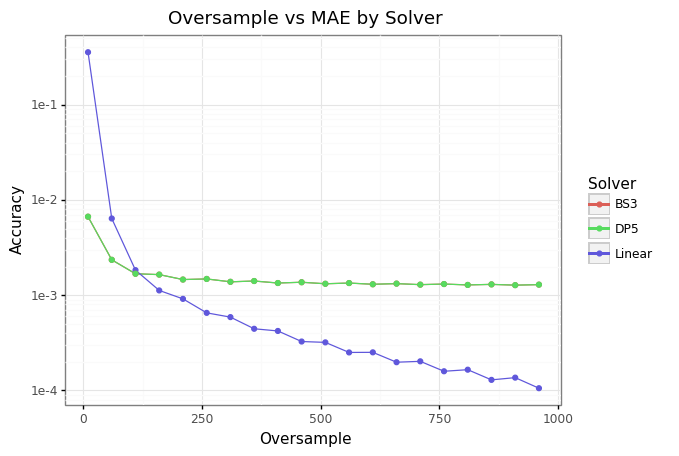

<ggplot: (8738690056331)>

In [14]:
(ggplot(odeint_oversample_resids, 
    aes(
        x="Oversample", 
        y="Accuracy", 
        color="Solver"
    ))
    + theme_bw()
    + geom_line()
    + geom_point()
    + scale_y_log10()
    + ggtitle("Oversample vs MAE by Solver"))

In [15]:
odeint_oversample_resids["ymin"] =\
     odeint_oversample_resids["Time (s)"] -\
     odeint_oversample_resids["Time Var (s)"]

odeint_oversample_resids["ymax"] =\
     odeint_oversample_resids["Time (s)"] +\
     odeint_oversample_resids["Time Var (s)"]

/home/jordan/anaconda3/envs/kitkat/lib/python3.9/site-packages/pandas-1.4.0rc0-py3.9-linux-x86_64.egg/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
/home/jordan/anaconda3/envs/kitkat/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_errorbar : Removed 40 rows containing missing values.


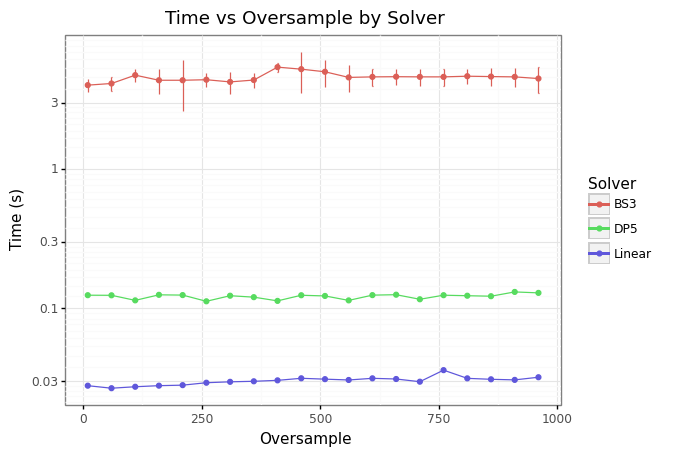

<ggplot: (8738690020858)>

In [16]:
(ggplot(odeint_oversample_resids, \
    aes(x="Oversample", y="Time (s)", ymin="ymin", ymax="ymax", color="Solver"))
    + theme_bw()
    + geom_line()
    + geom_point()
    + geom_errorbar()
    + scale_y_log10()
    + ggtitle("Time vs Oversample by Solver"))

Experimental analysis follows

In [18]:
loss_function_object.get_solver()

Partial(<function odeint at 0x7f2b0b526e50>, atol=1e-15, rtol=1e-15)

In [17]:
results = {
    "module": [],
    "time": [],
    "type": []
}

for solver in odeint:# Iterating through the namespaces of odeint function 
    loss_function_object.set_solver(odeint[solver])
    loss_function_object.parse_compilation_args()

    r_profile = profile(loss_function_object.dc14_fine, parameters)
    results["module"].append(solver)
    results["time"].append(float(r_profile["average"]) * 1000)
    results["type"].append("odeint")

    g_profile = profile(jacrev(loss_function_object.log_likelihood), parameters)
    results["module"].append(solver)
    results["time"].append(float(g_profile["average"]) * 1000)
    results["type"].append("gradient")

    h_profile = profile(jacfwd(jacrev(loss_function_object.log_likelihood)), parameters)
    results["module"].append(solver)
    results["time"].append(float(h_profile["average"]) * 1000)
    results["type"].append("hessian")


ValueError: Reverse-mode differentiation does not work for lax.while_loop or lax.fori_loop. Try using lax.scan instead.

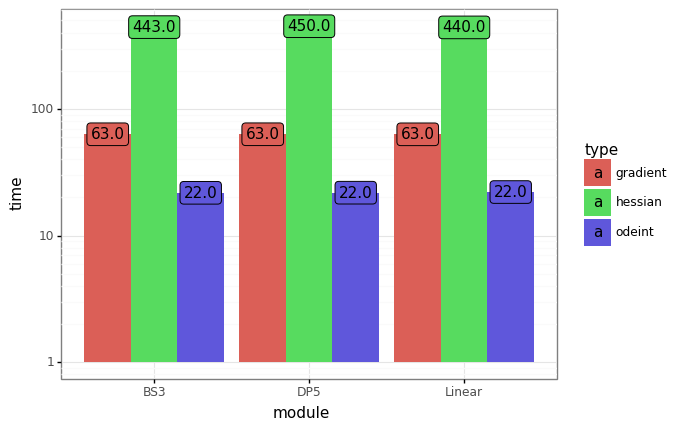

<ggplot: (8726924945917)>

In [ ]:
results = DataFrame(results)  # Switching to a pandas data frame
(ggplot(results, aes(x="module", y="time", fill="type"))
    + geom_col(position="dodge")
    + geom_label(aes(label="round(time)"), position=position_dodge(width=0.9))
    + scale_y_log10()
    + theme_bw())